## Imports

In [1]:
import json
import os
import pickle
import torch

import ccc
import utils
import utils_plots
import utils_shap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.patches import Patch

/home/noxthot/anaconda3/envs/meteorology_verticallearning/lib/python3.7/site-packages/petastorm/spark/spark_dataset_converter.py:28: FutureWarning: pyarrow.LocalFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  from pyarrow import LocalFileSystem


## Settings

### General

In [2]:
PATH_DATA_SOURCE = os.path.join('.', 'data', 'netcdf_raw')

TARGET_MODE = 1
MODELDIR = "2022_02_21__11-11"

## Preparations

In [3]:
tmsubdir = f'targetmode_{TARGET_MODE}'
model_root_tm_path = os.path.join(ccc.MODEL_ROOT_PATH, tmsubdir)
    
modelpath = os.path.join(model_root_tm_path, MODELDIR)

In [4]:
with open(os.path.join(modelpath, 'train_monitor.pickle'), 'rb') as f:
    train_monitor = pickle.load(f)
    
_, best_epoch = utils.getOptThresholdFromVal(train_monitor)

_, model_name = utils.load_model(os.path.join(f'targetmode_{TARGET_MODE}', MODELDIR), torch.device("cpu"), best_epoch)

shap_path = os.path.join(modelpath, f"{model_name}_shap_parquet")
df_path = os.path.join(modelpath, f"{model_name}_test_df.pickle")

Loading model from ./data/models/targetmode_1/2022_02_21__11-11/_model_00018.pt


In [5]:
with open(os.path.join(modelpath, f'{model_name}_test_scores.json'), 'r') as f:
    test_scores_json = json.load(f)
    
dd = pd.read_pickle(df_path)

In [6]:
dd.columns

Index(['output', 'target', 'longitude', 'latitude', 'hour', 'day', 'month',
       'year'],
      dtype='object')

In [7]:
vis_save_path = os.path.join(modelpath, f"{model_name}_shap_plots")

if vis_save_path != "":
    if not os.path.isdir(vis_save_path):
        os.makedirs(vis_save_path)

In [8]:
vc_threshold = utils.getVeryConfidentThreshold(test_scores_json["used_threshold"])
dd_transf = dd

dd_transf.loc[:, "pred_class"] = np.where(dd_transf["output"] > test_scores_json["used_threshold"], "pred_flash", "pred_no_flash")
dd_transf.loc[:, "real_class"] = np.where(dd_transf["target"] > 0.5, "real_flash", "real_no_flash")  # target col only contains 0s and 1s.

dd_transf.loc[:, 'cat'] = np.select(
    [
        (dd_transf['pred_class'] == "pred_flash") & (dd_transf['real_class'] == "real_flash") & (dd_transf["output"] < vc_threshold), 
        (dd_transf['pred_class'] == "pred_flash") & (dd_transf['real_class'] == "real_flash") & (dd_transf["output"] >= vc_threshold), 
        (dd_transf['pred_class'] == "pred_no_flash") & (dd_transf['real_class'] == "real_flash"), 
        (dd_transf['pred_class'] == "pred_flash") & (dd_transf['real_class'] == "real_no_flash"), 
        (dd_transf['pred_class'] == "pred_no_flash") & (dd_transf['real_class'] == "real_no_flash"), 
    ], 
    [
        'TP_LC', 
        'TP_VC',
        'FN',
        'FP',
        'TN',
    ], 
    default='ERROR'
)

dd_transf.loc[:, 'cluster'] = np.select(
    [dd_transf['cat'] == "TP_LC", dd_transf['cat'] == "TP_VC", dd_transf['cat'] == "FN", dd_transf['cat'] == "FP", dd_transf['cat'] == "TN",],
    [0, 1, 2, 3, 4,],
    default=-1
)

dd_transf = dd_transf.rename(columns={"output": "pred_score"})

<AxesSubplot:xlabel='pred_score', ylabel='Count'>

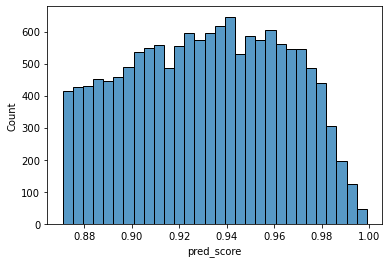

In [9]:
sns.histplot(dd_transf.query("cat in ['TP_LC', 'TP_VC']")['pred_score'])

In [10]:
np.median(dd_transf.query("cat in ['TP_LC', 'TP_VC']")['pred_score'])

0.9322703778743744

In [11]:
vc_threshold

0.935449093580246

In [12]:
# enrich with more data
metacols = ["cbh", "cth"]

for col in ccc.LVL_COLS:
    for lvl_idx in range(74):
        lvl = 64 + lvl_idx
        metacols.append(f"{col}_lvl{lvl}")

metacols.extend(ccc.INDEX_COLS)
metacols.extend(ccc.TRAIN_COLS)

metacols = list(set(metacols))

with open(os.path.join(modelpath, 'data_cfg.json'), 'r') as f:
    config_data = json.load(f)

print("Load test data into spark df", flush=True)
sparkdd_test = utils.get_testdf_spark(config_data, metacols, None).drop('features').drop('label')

print("Convert test data (excluding TNs) into spark df", flush=True)
spark = utils.getsparksession()
sparkdd = spark.createDataFrame(dd_transf.query("cat != 'TN'"))

print("Join the two dfs")
sparkdd = utils.joinDataframes(sparkdd, sparkdd_test)

print("Convert to pandas df")
dd_enriched = sparkdd.toPandas()

print("Free memory")
del sparkdd
del sparkdd_test

Load test data into spark df


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/12 08:42:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Convert test data (excluding TNs) into spark df
Join the two dfs
Convert to pandas df


22/10/12 08:42:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/10/12 08:42:27 WARN TaskSetManager: Stage 2 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


Free memory


/home/noxthot/anaconda3/envs/meteorology_verticallearning/lib/python3.7/site-packages/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


## Clustering

In [13]:
mask = (dd_enriched["cat"] == 'TP_VC') | (dd_enriched["cat"] == 'TP_LC')  # we only cluster for true positives
dd_tp = dd_enriched.loc[mask, :]
dd_fx = dd_enriched.loc[~mask, :]

In [14]:
dd_tp.head(10)

,longitude,latitude,year,month,day,hour,pred_score,target,pred_class,real_class,...,t_lvl120,ciwc_lvl107,t_lvl69,t_lvl132,t_lvl73,v_lvl85,v_lvl100,cswc_lvl92,cswc_lvl125,cswc_lvl81
5,8.25,45.75,2019,7,27,13,0.976450,1.0,pred_flash,real_flash,...,286.206390,4.377216e-08,220.196564,290.387543,224.663940,8.576206,4.881218,0.000116,2.328306e-10,0.000047
7,8.25,45.75,2019,8,12,14,0.949181,1.0,pred_flash,real_flash,...,287.733673,7.683411e-08,219.963501,292.259308,216.137695,32.675381,12.928480,0.000205,0.000000e+00,0.000067
26,8.50,45.75,2019,8,7,9,0.917163,1.0,pred_flash,real_flash,...,287.760437,0.000000e+00,215.021912,292.200378,214.545258,8.785868,11.955694,0.000253,0.000000e+00,0.000014
33,8.50,46.50,2019,7,25,23,0.966639,1.0,pred_flash,real_flash,...,284.697968,5.029724e-07,214.807251,289.906403,212.996765,6.530483,1.562866,0.000017,2.328306e-10,0.000018
35,8.50,46.50,2019,8,12,7,0.958127,1.0,pred_flash,real_flash,...,280.376617,1.632550e-06,218.720963,281.417419,217.037476,29.862906,18.990198,0.000075,0.000000e+00,0.000054
42,8.50,47.75,2019,6,20,16,0.878571,1.0,pred_flash,real_flash,...,285.562073,5.468028e-07,220.885483,291.897614,219.037842,5.900459,5.270426,0.000028,0.000000e+00,0.000001
44,8.50,48.00,2019,6,3,14,0.871632,1.0,pred_flash,real_flash,...,287.716461,5.650800e-07,214.922302,293.270050,211.975281,3.461958,7.344721,0.000024,0.000000e+00,0.000007
66,8.75,47.00,2019,7,6,14,0.962840,1.0,pred_flash,real_flash,...,284.978912,5.248003e-07,217.789017,289.888824,215.197083,3.899985,3.933684,0.000118,2.328306e-10,0.000006
73,8.75,48.75,2019,7,27,16,0.978824,1.0,pred_flash,real_flash,...,289.012573,0.000000e+00,222.751602,293.225311,221.067566,6.855579,2.181340,0.000180,2.328306e-10,0.000107
77,8.75,49.25,2019,8,9,20,0.969596,1.0,pred_flash,real_flash,...,294.269501,0.000000e+00,210.521271,299.709167,214.148926,8.759397,12.043930,0.000034,0.000000e+00,0.000018


In [15]:
[len(dd_tp), len(dd_fx)]

[14370, 77214]

In [16]:
size_of_smallest_cl = dd_enriched['cluster'].value_counts().min()
dd_enriched['cluster'].value_counts()

3    61446
2    15768
0     7640
1     6730
Name: cluster, dtype: int64

## Plotting Profiles

In [17]:
geoh_cols = [col for col in dd_enriched.columns if col.startswith("geoh_")]

df_many_cases = dd_enriched[ccc.INDEX_COLS + geoh_cols + ["cbh", "cth", 'cluster']]

In [18]:
len(df_many_cases)

91584

In [19]:
df_many_cases_sampled = df_many_cases.groupby('cluster').sample(size_of_smallest_cl)

In [20]:
len(df_many_cases_sampled)

26920

In [21]:
dshap = pd.read_parquet(shap_path) ## serves as test file
dshap.rename(columns={utils_shap.colname_meta_infix(col) : col for col in ccc.INDEX_COLS}, inplace=True)

In [22]:
df_many_cases_shap = utils.joinDataframes(df_many_cases_sampled, dshap)
df_many_cases_shap.drop(["flash_meta"], axis=1, inplace=True)

df_many_cases_shap = utils.addCloudHeight(df_many_cases_shap)

In [82]:
ptype = "q50"  # can be mult, q50, q95
use_cache = True
separate_clusters = False
plot_clusters = {
                    0: 'TP less confident',
                    1: 'TP very confident',
                    2: 'FN',
                    3: 'FP',
#                    4: 'TN',
                }

only_show_cols = []
#only_show_cols = ["ciwc", "cswc"]

y_axis = "geopotential_altitude"  # level, cloudscale_intpol, geopotential_altitude

In [83]:
# Used for debugging to quickly reload utils_plots.py
import importlib
importlib.reload(utils_plots)

<module 'utils_plots' from '/home/noxthot/uibk/meteorology/mlvapto/utils_plots.py'>

In [81]:
utils_plots.plot_many_profiles(df_many_cases_shap, "feature", ptype=ptype, y_axis=y_axis, separate_clusters=separate_clusters, save_path=vis_save_path, use_cache=use_cache, plot_clusters=plot_clusters, only_show_cols=only_show_cols)

Using cached file ./data/models/targetmode_1/2022_02_21__11-11/_model_00018_shap_plots/cached_profiles.pickle


/home/noxthot/anaconda3/envs/meteorology_verticallearning/lib/python3.7/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


<Figure size 905x504 with 0 Axes>

In [62]:
utils_plots.plot_many_profiles(df_many_cases_shap, "shap", ptype=ptype, y_axis=y_axis, separate_clusters=separate_clusters, save_path=vis_save_path, use_cache=use_cache, plot_clusters=plot_clusters, only_show_cols=only_show_cols)

Using cached file ./data/models/targetmode_1/2022_02_21__11-11/_model_00018_shap_plots/cached_profiles.pickle


/home/noxthot/anaconda3/envs/meteorology_verticallearning/lib/python3.7/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


<Figure size 909.625x504 with 0 Axes>

In [50]:
ucols = ["longitude", "latitude", "year", "month", "day", "hour", "cbh", "cth", "cluster"]
df_cbh_cth_grouped = df_many_cases.reset_index()[ucols].groupby(ucols)

In [51]:
cbh_ls = []
cth_ls = []
cluster_ls = []

for group, _ in df_cbh_cth_grouped:
    cbh_ls.append(group[ucols.index("cbh")])
    cth_ls.append(group[ucols.index("cth")])
    cluster_ls.append(group[ucols.index("cluster")])

In [52]:
df_cbh_cth = pd.DataFrame({"cbh" : cbh_ls, "cth" : cth_ls, "cluster" : cluster_ls})
df_cbh_cth["ch"] = df_cbh_cth["cth"] - df_cbh_cth["cbh"]
df_cbh_cth = df_cbh_cth[df_cbh_cth["cluster"].isin(plot_clusters.keys())]
df_cbh_cth["cluster_labels"] = df_cbh_cth["cluster"].replace(plot_clusters)

In [53]:
palette = sns.color_palette([utils_plots.CLUSTER_COLORS[col] for col in plot_clusters.keys()] if len(plot_clusters) > 0 else utils_plots.CLUSTER_COLORS)

In [54]:
legend_elements = [Patch(color=utils_plots.CLUSTER_COLORS[key], label=plot_clusters[key]) for key in plot_clusters]

In [55]:
cloud_medians = df_cbh_cth.groupby("cluster").median()

In [56]:
cloud_medians

,cbh,cth,ch
cluster,,,
0,984.605713,11567.952148,10422.373047
1,759.464355,12014.779297,11111.306152
2,1133.506348,10593.015137,9014.313477
3,942.211426,11711.100098,10582.997314


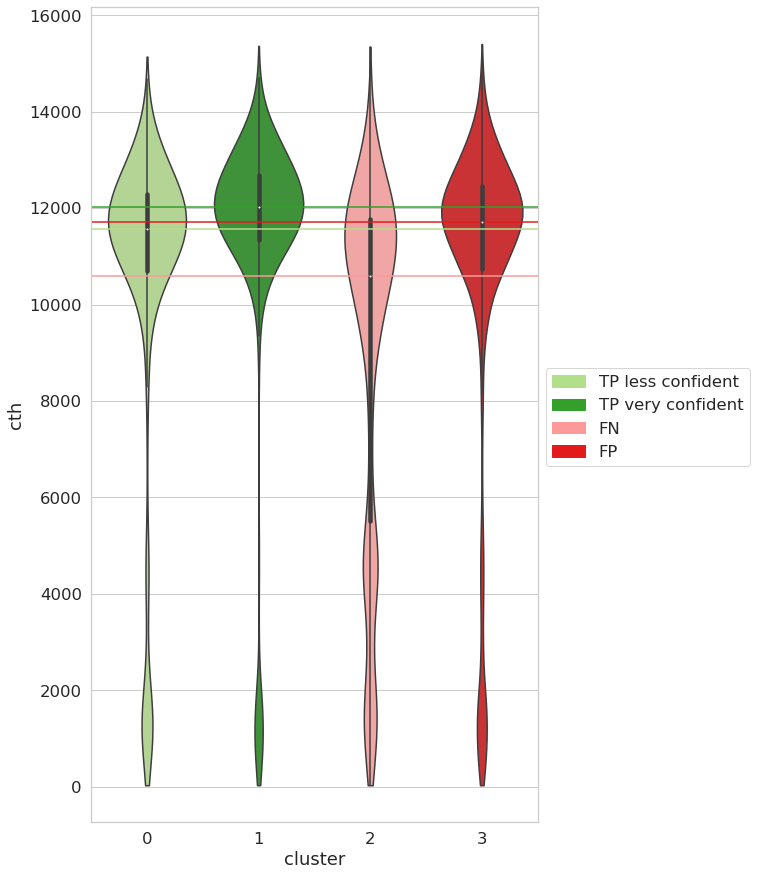

In [58]:
g = plt.figure(figsize=(8, 15))
graph = sns.violinplot(data=df_cbh_cth, x="cluster", y="cth", fliersize=3, palette=palette, cut=0)
g.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.9, 0.5))

for idx in plot_clusters.keys():
    graph.axhline(cloud_medians.query(f"cluster == {idx}")["cth"].values[0], color=utils_plots.CLUSTER_COLORS[idx])

ofile = os.path.join(vis_save_path, f"cth_violinplot")
g.savefig(f"{ofile}.pdf")
g.savefig(f"{ofile}.png")

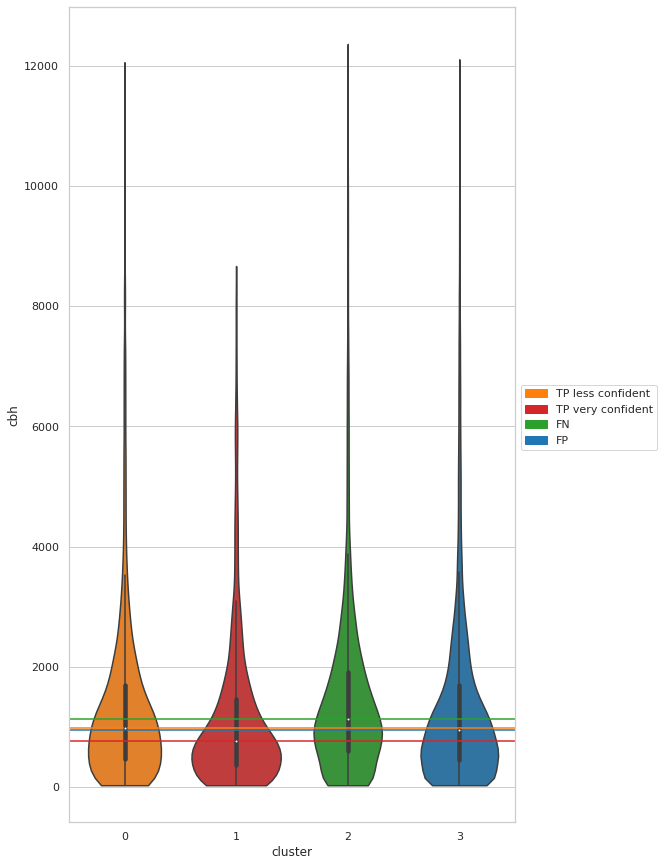

In [86]:
g = plt.figure(figsize=(8, 15))
graph = sns.violinplot(data=df_cbh_cth, x="cluster", y="cbh", fliersize=3, palette=palette, cut=0)
g.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.9, 0.5))

for idx in plot_clusters.keys():
    graph.axhline(cloud_medians.query(f"cluster == {idx}")["cbh"].values[0], color=utils_plots.CLUSTER_COLORS[idx])

ofile = os.path.join(vis_save_path, f"violinplot_cbh")
g.savefig(f"{ofile}.pdf")
g.savefig(f"{ofile}.png")

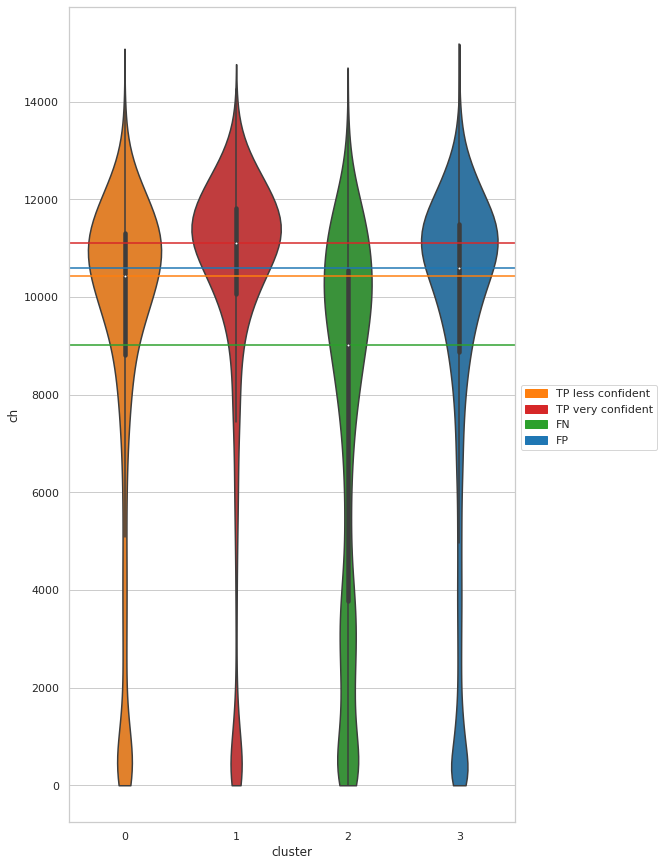

In [87]:
g = plt.figure(figsize=(8, 15))
graph = sns.violinplot(data=df_cbh_cth, x="cluster", y="ch", fliersize=3, palette=palette, cut=0)
g.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.9, 0.5))

for idx in plot_clusters.keys():
    graph.axhline(cloud_medians.query(f"cluster == {idx}")["ch"].values[0], color=utils_plots.CLUSTER_COLORS[idx])

ofile = os.path.join(vis_save_path, f"violinplot_ch")
g.savefig(f"{ofile}.pdf")
g.savefig(f"{ofile}.png")